Explore mean sea level in nowcast and nowcast-green

In [1]:
import datetime
import numpy as np
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import glob
from dateutil import tz

from nowcast.figures import shared, figures
from nowcast import analyze, residuals
from salishsea_tools import viz_tools
%matplotlib inline

In [2]:
def load_model_ssh(grid):
    ssh = grid.variables['sossheig'][:]
    time = grid.variables['time_counter']
    dates=nc.num2date(time[:], time.units)
    return ssh, dates

In [3]:
nowcast = '/results/SalishSea/nowcast/'
nowcast_green = '/results/SalishSea/nowcast-green/'
location = 'PointAtkinson'
tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
labels={nowcast: 'nowcast', nowcast_green: 'nowcast-green'}

grid_B = {}
grid_B[nowcast] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
grid_B[nowcast_green] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
mesh_mask = {}
mesh_mask[nowcast] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
mesh_mask[nowcast_green] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

runs = [nowcast, nowcast_green]

In [4]:
def load_ssh_time_series(d1,d2, runs):
    
    numdays = (d2-d1).total_seconds()/86400
    dates = [d1 + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

    ssh = {}
    time = {}
    for run in runs:
        d = dates[0]
        fname = glob.glob(os.path.join(run, d.strftime('%d%b%y').lower(), '*_1d_*_grid_T.nc'))[0]
        grid = nc.Dataset(fname)
        ssh[run], time[run] = load_model_ssh(grid)
        for d in dates[1:]:
            fname = glob.glob(os.path.join(run, d.strftime('%d%b%y').lower(), '*_1d_*_grid_T.nc'))[0]
            grid = nc.Dataset(fname)
            s,t = load_model_ssh(grid)
            ssh[run]=np.concatenate((ssh[run],s))
            time[run]=np.concatenate((time[run],t))
        tmask = mesh_mask[run].variables['tmask'][:,0,:,:]
        ssh[run] = np.ma.array(ssh[run], mask = np.ones(ssh[run].shape) - tmask)
    return ssh, time

# Sept 11 to 26, 2016

In [5]:
sdt = datetime.datetime(2016,9,11)
edt = datetime.datetime(2016,9,26)

ssh, time = load_ssh_time_series(sdt, edt, runs)

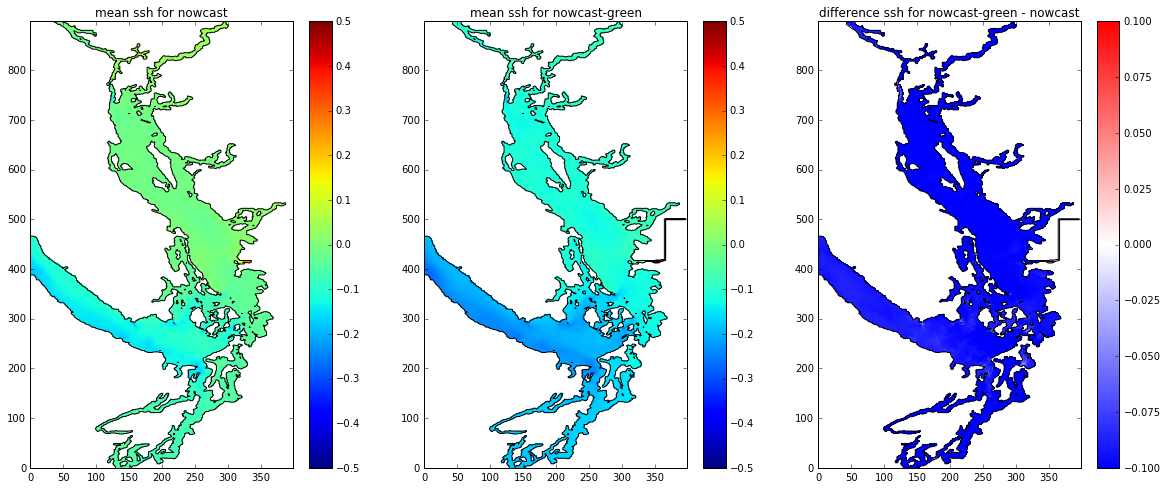

In [6]:
fig,axs = plt.subplots(1,3,figsize=(20,8))
for run, ax in zip(runs, axs):
    mesh=ax.pcolormesh(ssh[run].mean(axis=0),vmin=-.5,vmax=.5)
    plt.colorbar(mesh,ax=ax)
    ax.set_title('mean ssh for {}'.format(labels[run]))
    viz_tools.plot_coastline(ax, grid_B[run])
ax=axs[-1]
diff = ssh[nowcast_green].mean(axis=0) - ssh[nowcast].mean(axis=0)
mesh=ax.pcolormesh(diff,vmin=-.1,vmax=.1,cmap='bwr')
plt.colorbar(mesh,ax=ax)
ax.set_title('difference ssh for {} - {}'.format(labels[nowcast_green], labels[nowcast]))
viz_tools.plot_coastline(ax, grid_B[run])

In [7]:
for run in runs:
    print('{} mean ssh whole domain: {} m'.format(labels[run], np.mean(ssh[run])))

nowcast mean ssh whole domain: -0.05068201194654997 m
nowcast-green mean ssh whole domain: -0.14778545136372168 m


# Dec 12, 2015 to Oct 11, 2016

In [8]:
sdt = datetime.datetime(2015,12,12)
edt = datetime.datetime(2016,10,11)

ssh, time = load_ssh_time_series(sdt, edt, runs)

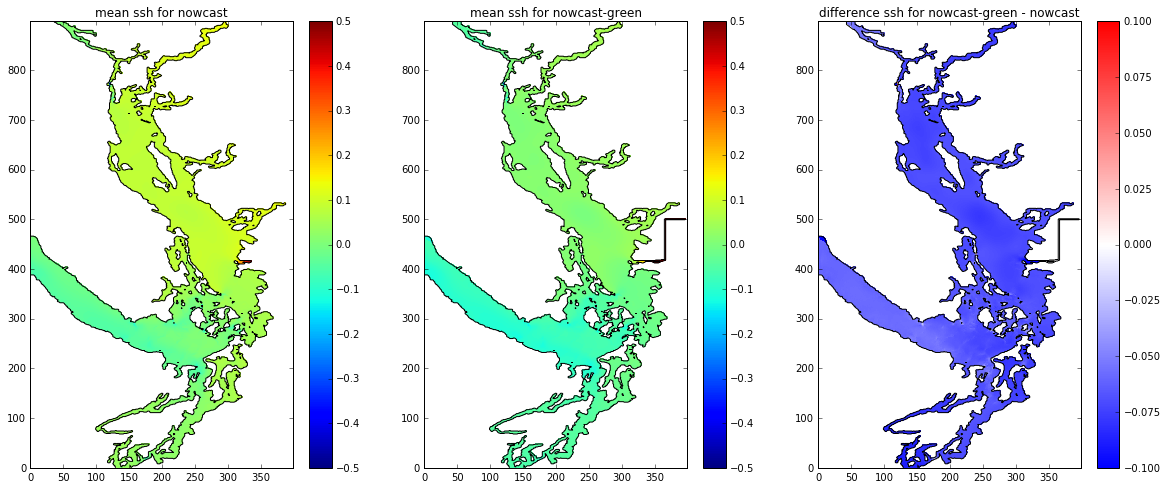

In [9]:
fig,axs = plt.subplots(1,3,figsize=(20,8))
for run, ax in zip(runs, axs):
    mesh=ax.pcolormesh(ssh[run].mean(axis=0),vmin=-.5,vmax=.5)
    plt.colorbar(mesh,ax=ax)
    ax.set_title('mean ssh for {}'.format(labels[run]))
    viz_tools.plot_coastline(ax, grid_B[run])
ax=axs[-1]
diff = ssh[nowcast_green].mean(axis=0) - ssh[nowcast].mean(axis=0)
mesh=ax.pcolormesh(diff,vmin=-.1,vmax=.1,cmap='bwr')
plt.colorbar(mesh,ax=ax)
ax.set_title('difference ssh for {} - {}'.format(labels[nowcast_green], labels[nowcast]))
viz_tools.plot_coastline(ax, grid_B[run])

In [10]:
for run in runs:
    print('{} mean ssh whole domain: {} m'.format(labels[run], np.mean(ssh[run])))

nowcast mean ssh whole domain: 0.04306697046398426 m
nowcast-green mean ssh whole domain: -0.023014445287752542 m


# Compare mean ssh to Neah Bay forcing anamoly

In [11]:
def NeahBay_forcing_time_series(d1, d2, results_path):
    """Create a time series of forcing ssh from Neah Bay between dates d1 and d2"""
    
    
    numdays = (d2-d1).days
    dates = [d1 + datetime.timedelta(days=i) for i in range(numdays)]
    
    tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
    surges = np.array([])
    times = np.array([])
    
    for d in dates:
        file_path = os.path.join(results_path, d.strftime('%d%b%y').lower())
        filename = glob.glob(os.path.join(file_path,'ssh*.txt'))
        if filename:
            time, surge, fflag = residuals.NeahBay_forcing_anom(filename[0], d, tides_path)
            surge_t, time_t = analyze.truncate_data(np.array(surge),
                                                     np.array(time), d, d+datetime.timedelta(days=1))
            surges = np.concatenate((surges, surge_t))
            times = np.concatenate((times, time_t))
    return surges, times

In [12]:
forcing, forcing_time = NeahBay_forcing_time_series(sdt.replace(tzinfo=tz.tzutc()), 
                                                    edt.replace(tzinfo=tz.tzutc()),
                                                    '/results/SalishSea/nowcast/')

(-0.5, 1)

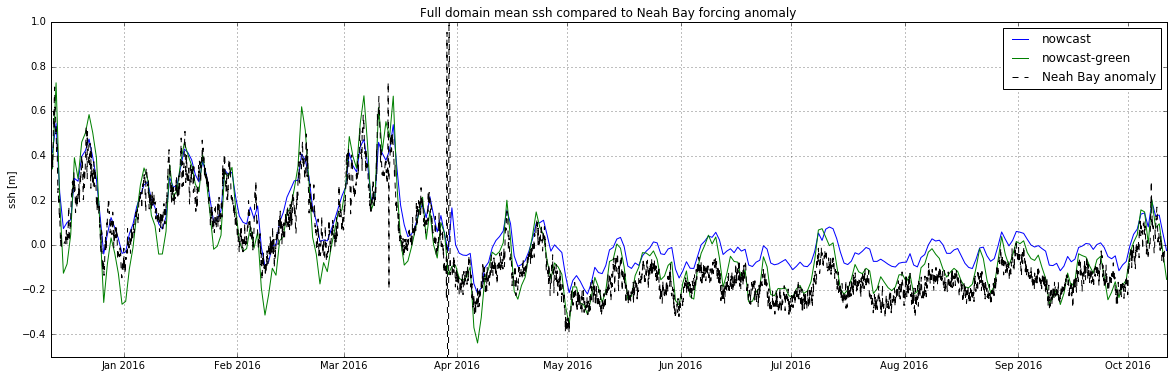

In [13]:
colors=['b','g']
fig,ax = plt.subplots(1,1,figsize=(20,6))
for run, c in zip(runs, colors):
    ax.plot(time[run],ssh[run].mean(axis=-1).mean(axis=-1),label=labels[run],color=c)
ax.plot(forcing_time, forcing, '--', label='Neah Bay anomaly',
        color='k')
ax.legend()
ax.grid()
ax.set_ylabel('ssh [m]')
ax.set_title('Full domain mean ssh compared to Neah Bay forcing anomaly')
ax.set_ylim([-.5,1])

Why is nowcast-green mean ssh so much lower? Rivers??